In [1]:
print("hello")

hello


In [2]:
import os
from datetime import datetime, timedelta, timezone
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [3]:
os.getcwd()

'/home/nico/git/theodolite/analysis'

In [16]:
exp_id = 4
warmup_sec = 60
warmup_partitions_sec = 120
threshold = 2000 #slope
#directory = '../results'
directory = '../execution'
directory_out = '.'


In [5]:
#exp_id = 35

#os.chdir("./results-final")

raw_runs = []

filenames = [filename for filename in os.listdir(directory) if filename.startswith(f"exp{exp_id}") and filename.endswith("totallag.csv")]
for filename in filenames:
    #print(filename)
    run_params = filename[:-4].split("_")
    dim_value = run_params[2]
    instances = run_params[3]

    df = pd.read_csv(os.path.join(directory, filename))
    #input = df.loc[df['topic'] == "input"]
    input = df
    #print(input)
    input['sec_start'] = input.loc[0:, 'timestamp'] - input.iloc[0]['timestamp']
    #print(input)
    #print(input.iloc[0, 'timestamp'])
    regress = input.loc[input['sec_start'] >= warmup_sec] # Warm-Up
    #regress = input

    #input.plot(kind='line',x='timestamp',y='value',color='red')
    #plt.show()

    X = regress.iloc[:, 2].values.reshape(-1, 1)  # values converts it into a numpy array
    Y = regress.iloc[:, 3].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    Y_pred = linear_regressor.predict(X)  # make predictions

    trend_slope = linear_regressor.coef_[0][0]
    #print(linear_regressor.coef_)

    row = {'dim_value': int(dim_value), 'instances': int(instances), 'trend_slope': trend_slope}
    #print(row)
    raw_runs.append(row)

lags = pd.DataFrame(raw_runs)


In [6]:
lags.head()

,dim_value,instances,trend_slope
0,100000,2,-6.412648


In [7]:

raw_partitions = []

filenames = [filename for filename in os.listdir(directory) if filename.startswith(f"exp{exp_id}") and filename.endswith("partitions.csv")]
for filename in filenames:
    #print(filename)
    run_params = filename[:-4].split("_")
    dim_value = run_params[2]
    instances = run_params[3]

    df = pd.read_csv(os.path.join(directory, filename))
    #input = df.loc[df['topic'] == "input"]
    input = df
    #print(input)
    input['sec_start'] = input.loc[0:, 'timestamp'] - input.iloc[0]['timestamp']
    #print(input)
    #print(input.iloc[0, 'timestamp'])
    input = input.loc[input['sec_start'] >= warmup_sec] # Warm-Up
    #regress = input

    input = input.loc[input['topic'] >= 'input']
    mean = input['value'].mean()

    #input.plot(kind='line',x='timestamp',y='value',color='red')
    #plt.show()


    row = {'dim_value': int(dim_value), 'instances': int(instances), 'partitions': mean}
    #print(row)
    raw_partitions.append(row)


partitions = pd.DataFrame(raw_partitions)

#runs = lags.join(partitions.set_index(['dim_value', 'instances']), on=['dim_value', 'instances'])

In [8]:
raw_obs_instances = []

filenames = [filename for filename in os.listdir(directory) if filename.startswith(f"exp{exp_id}") and filename.endswith("instances.csv")]
for filename in filenames:
    run_params = filename[:-4].split("_")
    dim_value = run_params[2]
    instances = run_params[3]

    df = pd.read_csv(os.path.join(directory, filename))

    if df.empty:
        continue

    #input = df.loc[df['topic'] == "input"]
    input = df
    #print(input)
    input['sec_start'] = input.loc[0:, 'timestamp'] - input.iloc[0]['timestamp']
    #print(input)
    #print(input.iloc[0, 'timestamp'])
    input = input.loc[input['sec_start'] >= warmup_sec] # Warm-Up
    #regress = input

    #input = input.loc[input['topic'] >= 'input']
    #mean = input['value'].mean()

    #input.plot(kind='line',x='timestamp',y='value',color='red')
    #plt.show()


    #row = {'dim_value': int(dim_value), 'instances': int(instances), 'obs_instances': mean}
    #print(row)
    raw_obs_instances.append(row)


obs_instances = pd.DataFrame(raw_obs_instances)

obs_instances.head()

,dim_value,instances,partitions
0,100000,2,40.0


In [9]:
runs = lags
#runs = lags.join(partitions.set_index(['dim_value', 'instances']), on=['dim_value', 'instances'])#.join(obs_instances.set_index(['dim_value', 'instances']), on=['dim_value', 'instances'])

#runs["failed"] = runs.apply(lambda row: (abs(row['instances'] - row['obs_instances']) / row['instances']) > 0.1, axis=1)

#runs.loc[runs['failed']==True]

In [10]:
#threshold = 1000

# Set to true if the trend line has a slope less than 
runs["suitable"] =  runs.apply(lambda row: row['trend_slope'] < threshold, axis=1)

runs.columns = runs.columns.str.strip()
runs.sort_values(by=["dim_value", "instances"])

,dim_value,instances,trend_slope,suitable
0,100000,2,-6.412648,True


In [11]:
filtered = runs[runs.apply(lambda x: x['suitable'], axis=1)]

grouped = filtered.groupby(['dim_value'])['instances'].min()
min_suitable_instances = grouped.to_frame().reset_index()

min_suitable_instances

,dim_value,instances
0,100000,2


In [17]:
min_suitable_instances.to_csv(os.path.join(directory_out, f'./exp{exp_id}_min-suitable-instances.csv'), index=False)

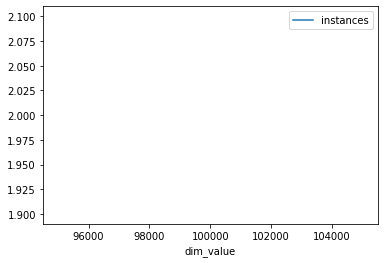

In [13]:
min_suitable_instances.plot(kind='line',x='dim_value',y='instances')
# min_suitable_instances.plot(kind='line',x='dim_value',y='instances', logy=True)

plt.show()